
# handle missing value



In [1]:
# import packages

# data processing
import pandas as pd
import numpy as np
from datetime import timedelta, datetime


import re

# data visualization
import plotly.graph_objs as go
from plotly.graph_objs import Bar, Layout
from plotly import offline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

# change text color
import colorama
from colorama import Fore, Style

# IPython
from IPython.display import IFrame

In [2]:


train = pd.read_csv('../../data/train.csv')
test = pd.read_csv('../../data/test.csv')

In [4]:

fullset = pd.concat([train,test],ignore_index=True)



- MCAR (Missing completely at Random)
- MAR (Missing at Random)
- MNAR (Missing not at Random)



In [5]:
def meta(train,test,missing_values = -1,cols_ignore_missing = []):
    
    df = pd.concat([train,test]).reset_index(drop=True).fillna('未知')
    data = []
    for col in df.columns:

        if col == 'target':
            role = 'target'
        elif col == 'id':
            role = 'id'
        else:
            role = 'feature'
        

        if 'ind' in col:
            category = 'individual'
        elif 'car' in col:
            category = 'car'
        elif 'calc' in col:
            category = 'calculated'
        elif 'reg' in col:
            category = 'region'
        else:
            category = 'other'
        
        
        if 'bin' in col or col == 'target':
            level = 'binary'
        elif 'cat' in col[-3:] or col == 'id':
            level = 'nominal'
        elif df[col].dtype == 'float64' and df[col].replace(missing_values,np.nan).max()-df[col].replace(missing_values,np.nan).min() > 1:
            level = 'interval'
        elif df[col].dtype == 'float64' and df[col].replace(missing_values,np.nan).max()-df[col].replace(missing_values,np.nan).min() <= 1:
            level = 'ratio'
        elif df[col].dtype == 'int64':
            level = 'ordinal'
            

        dtype = df[col].dtype
        

        if col == 'id' or df[col].dtype == 'float64':
            uniq = 'Ignore'
        else:
            if col in cols_ignore_missing:
                uniq = df[col].nunique()
            else:
                uniq = df[col].replace({missing_values:np.nan}).nunique()
                

        if uniq == 'Ignore':
            cardinality = 'Ignore'
        elif uniq <= 10:
            cardinality = 'Low Cardinality'
        elif uniq <= 30:
            cardinality = 'Medium Cardinality'
        else:
            cardinality = 'High Cardinality'
        
        if col in cols_ignore_missing:
            missing = 0
        else:
            missing = sum(df[col] == missing_values)
            
        # missing percent
        missing_percent = f'{missing}({round(missing*100/len(df),2)}%)'
        
        # imputation
        if missing > df.shape[0]*0.4:
            imputation = 'remove'
        elif missing > 0:
            if level == 'binary' or level == 'nominal':
                imputation = ('mode')
            if level == 'ordinal':
                imputation = ('mode','median')
            if level == 'interval' or level == 'ratio':
                imputation = ('mode','median','mean')        
        else:
            imputation = "No Missing"
            
        # keep
        keep = True
        if col  == 'id' or imputation == 'remove':
            keep = False
        col_dict = {
            'colname': col,
            'role': role,
            'category': category,
            'level': level,
            'dtype': dtype,
            'cardinality': uniq,
            'cardinality_level':cardinality,
            'missing': missing,
            'missing_percent': missing_percent,
            'imputation':imputation,
            'keep': keep,
        }
        data.append(col_dict)
    meta = pd.DataFrame(data, columns=list(col_dict.keys()))
    meta.set_index('colname', inplace=True)
    
    return meta

In [6]:
metadata = meta(train,test)

In [7]:
missing_data = metadata[['missing','missing_percent','imputation']][metadata['missing']>0].sort_values(by = 'missing',ascending=False)

In [8]:
missing_data

,missing,missing_percent,imputation
colname,,,
ps_car_03_cat,1028142,1028142(69.09%),remove
ps_car_05_cat,666910,666910(44.82%),remove
ps_reg_03,269456,269456(18.11%),"(mode, median, mean)"
ps_car_14,106425,106425(7.15%),"(mode, median, mean)"
ps_car_07_cat,28820,28820(1.94%),mode
ps_ind_05_cat,14519,14519(0.98%),mode
ps_car_09_cat,1446,1446(0.1%),mode
ps_ind_02_cat,523,523(0.04%),mode
ps_car_01_cat,267,267(0.02%),mode


In [8]:
cols_to_drop = missing_data[missing_data.imputation == 'remove'].index.to_list()

In [9]:
cols_to_imp = missing_data.index[2:].to_list()
cols_to_imp_3m = missing_data[missing_data.imputation == ('mode', 'median', 'mean')].index.to_list()
cols_to_imp_2m = missing_data[missing_data.imputation == ('mode', 'median')].index.to_list()
cols_to_imp_1m = missing_data[missing_data.imputation == ('mode')].index.to_list()

In [10]:
#! pip install missingno

In [11]:
import missingno as msno

<AxesSubplot:>

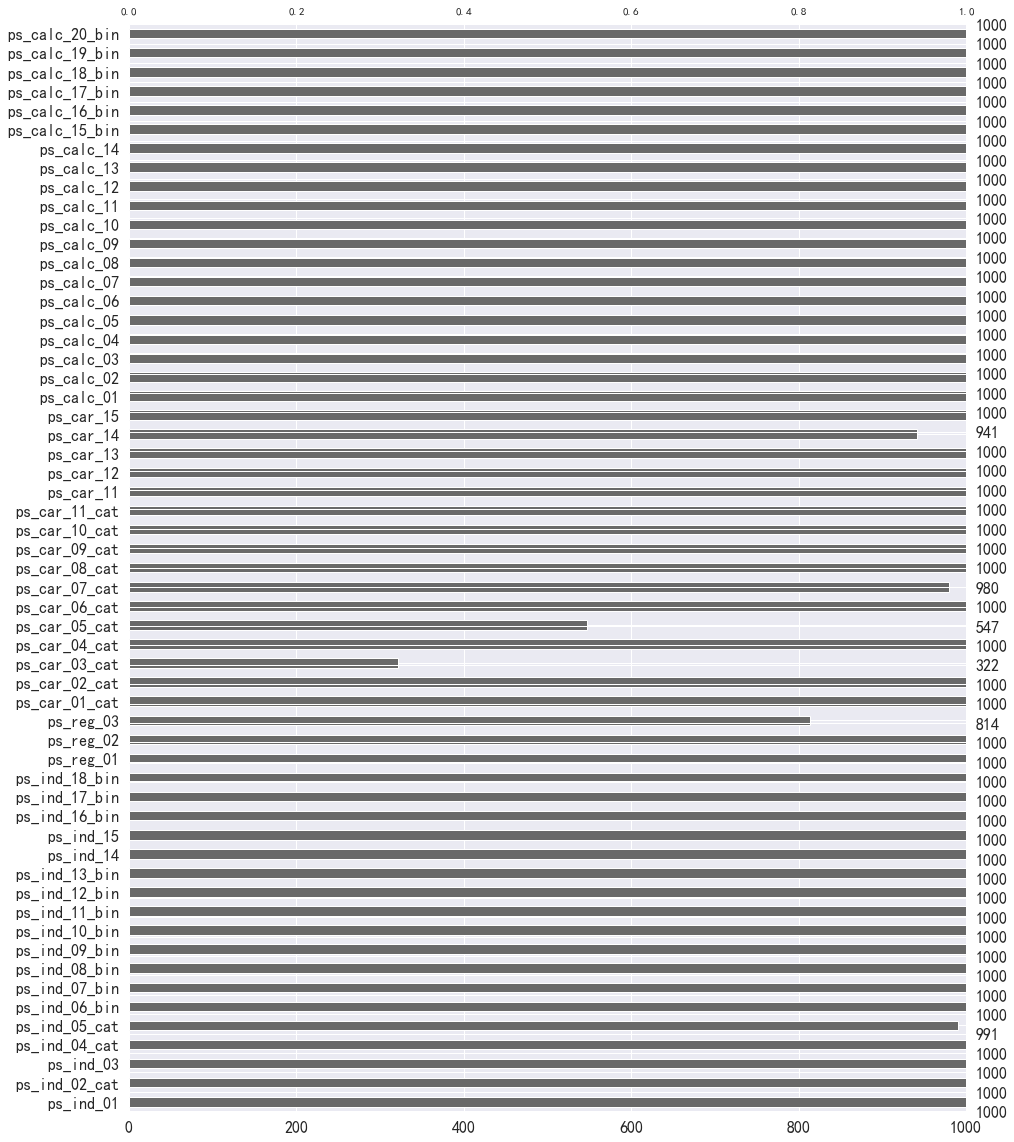

In [11]:
msno.bar(fullset.drop(['id','target'],axis=1).replace(-1,np.nan).sample(1000),figsize = [15,20]) 

<AxesSubplot:>

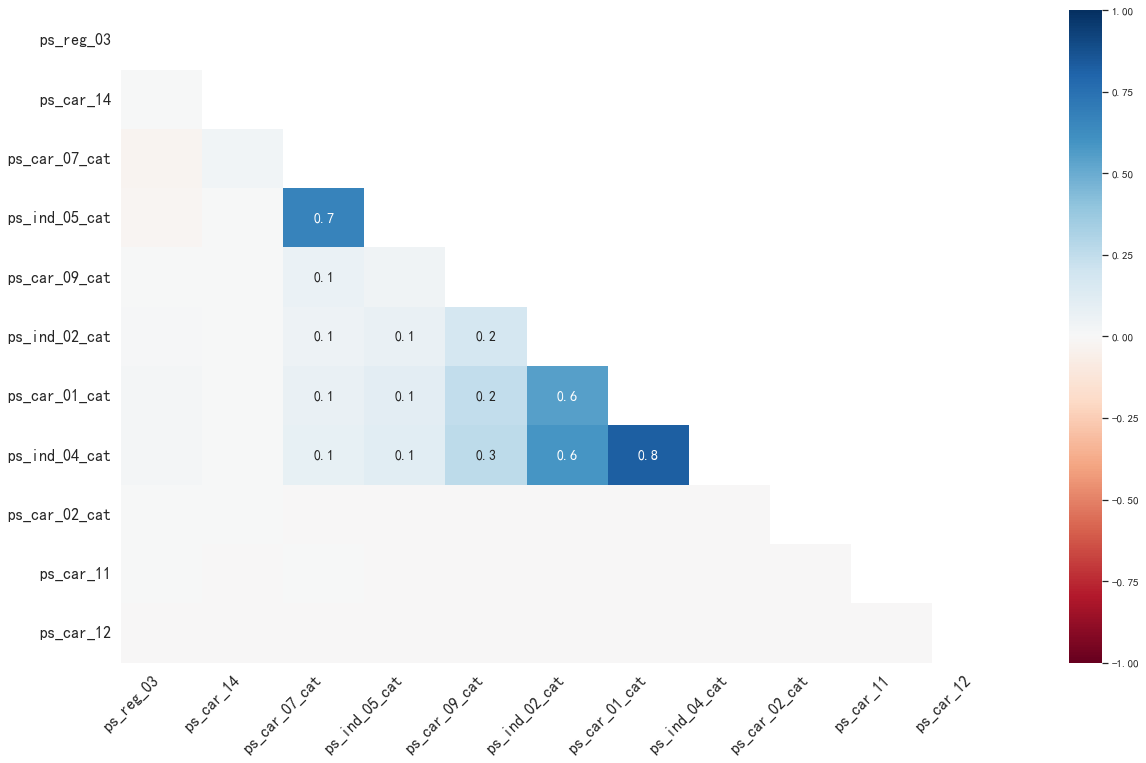

In [13]:
msno.heatmap(fullset[cols_to_imp].replace(-1,np.nan))

<AxesSubplot:>

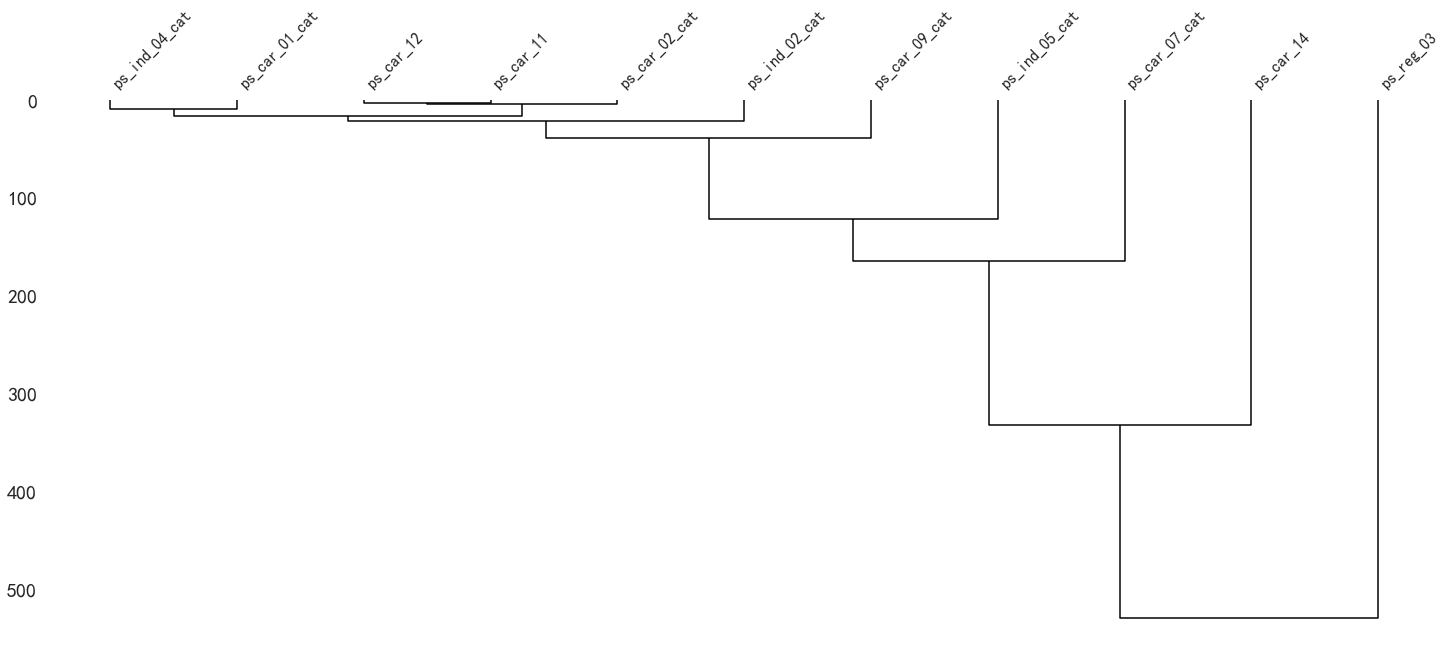

In [14]:
msno.dendrogram(fullset[cols_to_imp].replace(-1,np.nan))

## Imputation



From the above diagram, we can see the degree of association between missing values for each pair of variables. For example:

The absence of ps_car_01_cat will lead to the absence of ps_ind_04_cat, indicating a positive relationship with a significant degree of association!

From the diagram, we can see that we attempt to use multivariate imputation methods to fill in variables that are related!

- ps_ind_05_cat | ps_car_07_cat
- ps_car_01_cat | ps_ind_02_cat | ps_ind_04_cat
- ps_reg_03 | ps_car_14 (continuous)

In [12]:
set1 = ['ps_ind_05_cat','ps_car_07_cat']
set2 = ['ps_car_01_cat','ps_ind_02_cat','ps_ind_04_cat']
set3 = ['ps_reg_03','ps_car_14']

#### MICE



In [13]:
%%time

from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10, random_state=123)

imp_mean = IterativeImputer(estimator=rf, missing_values=-1, random_state=0)
set1_imp = imp_mean.fit_transform(train[set1])

CPU times: user 1.81 s, sys: 154 ms, total: 1.97 s
Wall time: 2.2 s


In [14]:
%%time
set2_imp = imp_mean.fit_transform(train[set2])

CPU times: user 6.7 s, sys: 121 ms, total: 6.82 s
Wall time: 7.25 s


In [15]:
%%time
set3_imp = imp_mean.fit_transform(train[set3])

CPU times: user 1min 6s, sys: 643 ms, total: 1min 7s
Wall time: 1min 8s


/Users/janceyliu/opt/anaconda3/envs/2060/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



In [16]:
pd.DataFrame(set3_imp,columns = set3)

,ps_reg_03,ps_car_14
0,0.718070,0.370810
1,0.766078,0.388716
2,0.855884,0.347275
3,0.580948,0.294958
4,0.840759,0.365103
...,...,...
595207,0.692820,0.385487
595208,1.382027,0.378471
595209,0.659071,0.398748
595210,0.698212,0.384968


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

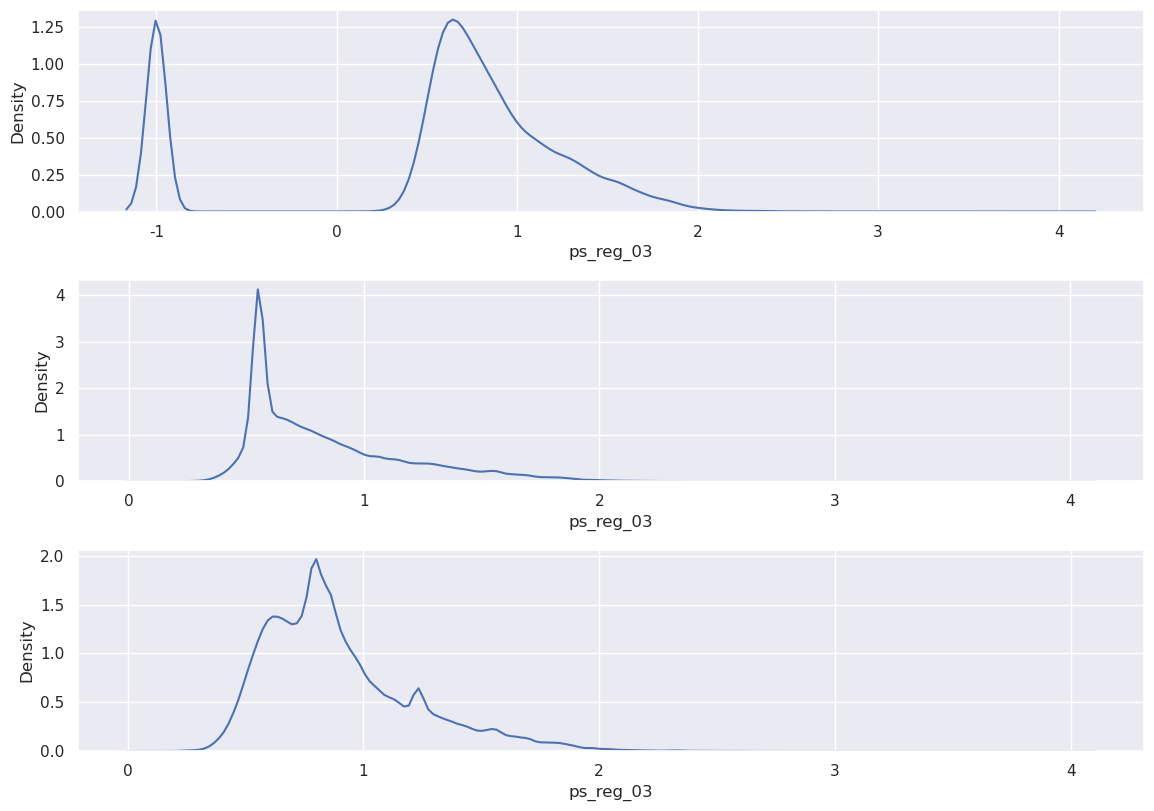

In [17]:
plt.subplot(3,1,1)
sns.kdeplot(train[set3[0]])
plt.subplot(3,1,2)
sns.kdeplot(train[set3[0]].replace(-1,np.nan).fillna(train[set3[0]].mean()))
plt.subplot(3,1,3)
sns.kdeplot(pd.DataFrame(set3_imp,columns = set3)[set3[0]])

plt.tight_layout()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

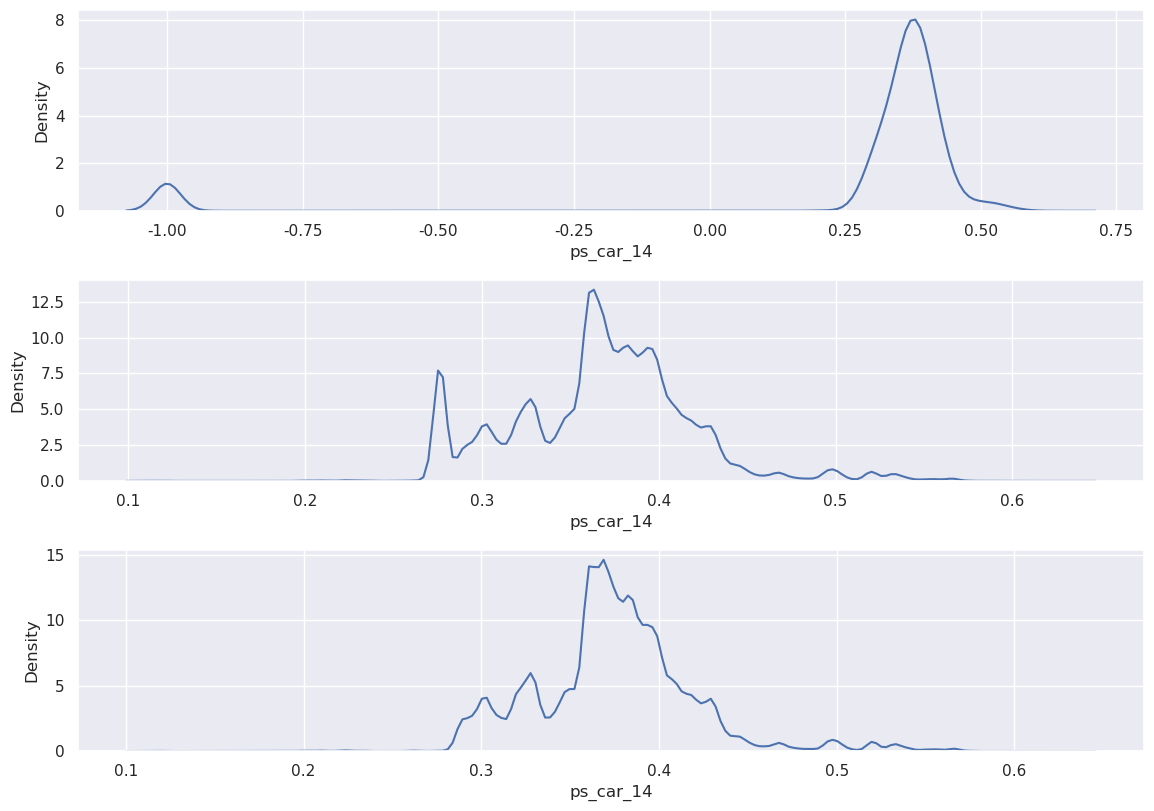

In [18]:
plt.subplot(3,1,1)
sns.kdeplot(train[set3[1]])
plt.subplot(3,1,2)
sns.kdeplot(train[set3[1]].replace(-1,np.nan).fillna(train[set3[1]].mean()))
plt.subplot(3,1,3)
sns.kdeplot(pd.DataFrame(set3_imp,columns = set3)[set3[1]])

plt.tight_layout()

可以看出，MICE可以更好地吻合原变量的概率分布，所以我们选择使用MICE填充！

In [ ]:
train[set3] = pd.DataFrame(set3_imp,columns = set3)




- fillna
- replace
- SimpleImputer
- Intepolate

SimpleImputer



- If "<font color=red>mean</font>", then replace missing values using the mean along each column. Can only be used with numeric data.
- If "<font color=red>median</font>", then replace missing values using the median along
  each column. Can only be used with numeric data.
- If "<font color=red>most_frequent</font>", then replace missing using the most frequent
  value along each column. Can be used with strings or numeric data.
  If there is more than one such value, only the smallest is returned.
- If "<font color=red>constant</font>", then replace missing values with fill_value. Can be
  used with strings or numeric data.

In [ ]:
from sklearn.impute import SimpleImputer 

In [ ]:
mode_imputer = SimpleImputer(missing_values = -1, strategy='most_frequent',add_indicator=True)

In [ ]:
missing_data[4:]


In [ ]:
imp = mode_imputer.fit_transform(train[missing_data[4:].index])

In [ ]:
train[missing_data[4:].index]=pd.DataFrame(imp).iloc[:,:len(missing_data[4:].index)]

In [ ]:
train[missing_data[4:].index] = train[missing_data[4:].index].astype('int64')

In [ ]:
# drop columns
train.drop(cols_to_drop,axis=1,inplace=True)

In [ ]:
# check out if we still have -1 
(train == -1).sum().sum()

In [ ]:
train.to_csv('train_imp.csv')